<a href="https://colab.research.google.com/github/wumouyan/Colaboratory-Notes/blob/master/bds3_b2a_acq_publish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beidou B2a

## Open file

Fetch recorded antenna data from file in Google Drive.

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1VMtTqkcuBAhiEBNLf3r9xeM8itp_qyiG'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data');

## Read file

Read the recorded antenna data file and do a very simple sanity check by plotting the I/Q values in a histogram. They should be balanced, because there can not be an offset in the received signal. This verifies the correct functionality of the signal sampling.

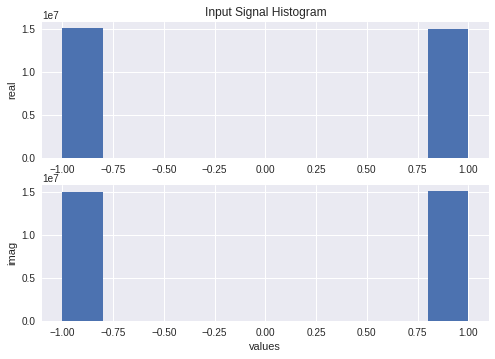

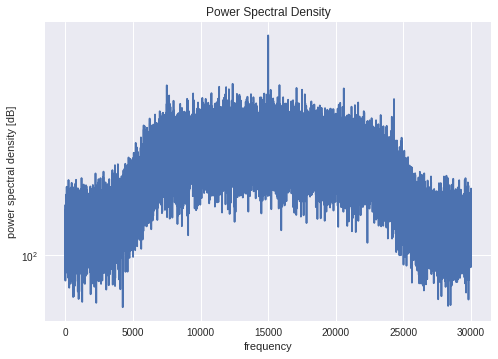

In [0]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt

# Parameters Signal
FCHIP = 10.230e6
FCENTER = 1176.45e6
CODE_LEN = 10230
CODE_PERIOD = CODE_LEN / FCHIP

# Parameters File
FS = 30e6
FCENTER_REC = 1177.5e6
FIF = FCENTER - FCENTER_REC
INTERLEAVED = 1
SAMP_PER_MS = int(round(FS / 1000))

# Parameters Simulation
NUM_MS = 1000
SAMPLES = NUM_MS * SAMP_PER_MS
NUM_SAMPLES_SKIP = 3*4660

x = np.fromfile('data', dtype='int8', 
                count=(INTERLEAVED+1)*(SAMPLES + NUM_SAMPLES_SKIP))
x = x[2*NUM_SAMPLES_SKIP:]

# Separate interleaved samples for I/Q
i = x[0::2]
q = x[1::2]

plt.subplot(2,1,1)
plt.title('Input Signal Histogram')
plt.hist(i)
plt.ylabel('real')
plt.subplot(2,1,2)
plt.hist(q)
plt.xlabel('values')
plt.ylabel('imag')
plt.show()

# Compute complex values and reshape
sig = i + 1j * q
sig = sig.reshape((NUM_MS, SAMP_PER_MS))

# Average spectrum for 10ms
psd_avg = 0
for k in range(0,10):
  psd_avg += fft.fftshift(abs(fft.fft(sig[k,:])))
psd_avg /= 10.

plt.semilogy(psd_avg)
plt.title('Power Spectral Density')
plt.ylabel('power spectral density [dB]')
plt.xlabel('frequency')
plt.show()

## Generate Codes

Codes are generated according to the ICD. The code needs to be up-sampled to 30 Msps, to match the sampling rate FS of the incoming signal. 

In [0]:
b2ai_init = {
   1: [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
   2: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
   3: [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1],
   4: [1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1],
   5: [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
   6: [1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0],
   7: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
   8: [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
   9: [1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1],
  10: [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0],
  11: [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1],
  12: [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
  13: [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1],
  14: [1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1],
  15: [1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0],
  16: [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1],
  17: [1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1],
  18: [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
  19: [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0],
  20: [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1],
  21: [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1],
  22: [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1],
  23: [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0],
  24: [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0],
  25: [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0],
  26: [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
  27: [1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
  28: [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
  29: [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0],
  30: [1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1],
  31: [1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0],
  32: [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
  33: [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1],
  34: [1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
  35: [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
  36: [1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
  37: [1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
  38: [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
  39: [1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1],
  40: [1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1],
  41: [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1],
  42: [1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0],
  43: [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1],
  44: [1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0],
  45: [1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1],
  46: [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
  47: [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
  48: [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
  49: [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1],
  50: [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1],
  51: [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0],
  52: [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1],
  53: [1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1],
  54: [1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0],
  55: [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0],
  56: [1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
  57: [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
  58: [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0],
  59: [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
  60: [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
  61: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
  62: [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
  63: [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0]
}

def b2ai(prn):
    g1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1])
    g2 = np.array(b2ai_init[prn])
 
    output = np.empty(CODE_LEN, dtype=int)

    for chip in range(CODE_LEN):
      output[chip] = g1[12] ^ g2[12]

      g1_new = g1[0] ^ g1[4] ^ g1[10] ^ g1[12] 
      g2_new = g2[2] ^ g2[4] ^ g2[8] ^ g2[10] ^ g2[11] ^ g2[12]
      
      g1 = np.roll(g1, 1)
      g1[0] = g1_new 
      g2 = np.roll(g2, 1)
      g2[0] = g2_new
      
      if chip==8189:
        g1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1])
    return output
  
b2aq_init = {
   1: [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
   2: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
   3: [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1],
   4: [1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1],
   5: [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
   6: [1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0],
   7: [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
   8: [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
   9: [1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1],
  10: [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0],
  11: [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1],
  12: [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
  13: [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1],
  14: [1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1],
  15: [1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0],
  16: [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1],
  17: [1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1],
  18: [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
  19: [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0],
  20: [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1],
  21: [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1],
  22: [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1],
  23: [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0],
  24: [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0],
  25: [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0],
  26: [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
  27: [1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
  28: [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
  29: [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0],
  30: [1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1],
  31: [1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0],
  32: [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
  33: [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1],
  34: [1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
  35: [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
  36: [1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
  37: [1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1],
  38: [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
  39: [1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1],
  40: [1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1],
  41: [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1],
  42: [1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0],
  43: [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1],
  44: [1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0],
  45: [1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1],
  46: [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
  47: [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
  48: [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
  49: [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1],
  50: [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1],
  51: [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0],
  52: [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1],
  53: [1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1],
  54: [1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0],
  55: [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0],
  56: [1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
  57: [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
  58: [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0],
  59: [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
  60: [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
  61: [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
  62: [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
  63: [0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
}

def b2aq(prn):
    g1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1])
    g2 = np.array(b2aq_init[prn])
 
    output = np.empty(CODE_LEN, dtype=int)

    for chip in range(CODE_LEN):
      output[chip] = g1[12] ^ g2[12]
      
      g1_new = g1[2] ^ g1[5] ^ g1[6] ^ g1[12] 
      g2_new = g2[0] ^ g2[4] ^ g2[6] ^ g2[7] ^ g2[11] ^ g2[12]
      
      g1 = np.roll(g1, 1)
      g1[0] = g1_new 
      g2 = np.roll(g2, 1)
      g2[0] = g2_new
      
      if chip==8189:
        g1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1])
    return output
  
# Generate codes
codes = [(1 - 2 * b2ai(prn)) for prn in range(1,38)]

# Resample codes
idx = np.arange(SAMP_PER_MS)
np.floor(idx * FCHIP / FS, out=idx, casting='unsafe')

resamp_codes = []
for code in codes:
  resamp_codes.append(code[idx])

## Acquisition

This is done through a parallel acquisition approach, using FFT for the correlation.

In [0]:
# Parameters
THRESHOLD = 1500
DOPP_MAX = 3000
DOPP_STEP = 600

t = np.linspace(0, CODE_PERIOD, num=SAMP_PER_MS, endpoint=False)
candidates = []

for i, code in enumerate(resamp_codes):  
  for freq in range (-DOPP_MAX, DOPP_MAX, DOPP_STEP):
    baseband =(sig[0,:] * np.exp(-2*np.pi*1j*t*(FIF+freq)))
    xcorr = abs(fft.ifft(fft.fft(baseband) * np.conj(fft.fft(code))))
    xcorr_max = max(xcorr)
    xcorr_max_idx = np.argmax(xcorr)
    if xcorr_max >= THRESHOLD:
      candidates.append((i+1, freq, xcorr_max_idx, xcorr_max))

# Print acquired satellites
print('prn\tdoppler \tsample_idx\tcorr value')
for c in candidates:
  print('%2d \t %5d \t\t %4d \t\t %5.2f' % (c[0],c[1],c[2],c[3]))


prn	doppler 	sample_idx	corr value
20 	  1200 		 3306 		 1629.87
29 	     0 		   14 		 1843.57


## Tracking

Doppler recovery is done by looking at phase drift.

We choose to track satellite PRN 29, from looking at the acquisition results. 
It was acquired at a doppler of 0 Hz, so we kick off tracking there.

In [0]:
# Parameter
SAT = 29
ALPHA_LP = 0.1
DOPP_FREQ_INIT = 0

dopp_freq = [DOPP_FREQ_INIT]
xcorr_max = {}
a_diff_vals = {}
trk_sample_idx = {}
phase_init = 0
bits = [1]

code = resamp_codes[SAT-1]

# Loop through single milliseconds
for ms in range(NUM_MS):

  # Modulate to baseband with current estimated doppler
  phase = 2*np.pi*(FIF+dopp_freq[-1])
  baseband = sig[ms,:] * np.exp(-1j*(phase_init + phase*t))
  phase_init = phase_init + phase * CODE_PERIOD

  # Cross-correlate and get complex maximum
  xcorr = fft.ifft(fft.fft(baseband) * np.conj(fft.fft(code)))
  xcorr_max_idx = np.argmax(abs(xcorr))
  xcorr_max[ms] = xcorr[xcorr_max_idx]
  trk_sample_idx[ms] = xcorr_max_idx

  # Calculate phase difference from last ms
  if ms >= 1:
    a0 = np.angle(xcorr_max[ms-1]) / (2 * np.pi)
    a1 = np.angle(xcorr_max[ms]) / (2 * np.pi)
    a_diff = a1 - a0
    
    # Limit rotation to +/- 0.5 cycle
    if a_diff > +0.5:
      a_diff -= 1.0
    if a_diff < -0.5:
      a_diff += 1.0

    # Determine databit transition
    flip = 1
    if a_diff > +0.25:
      a_diff -= 0.5
      flip = -1
    elif a_diff < -0.25:
      a_diff += 0.5
      flip = -1
      
    bits.append(bits[-1] * flip)
      
    a_diff_vals[ms] = a_diff
    target_dopp_freq = dopp_freq[-1] + (a_diff / CODE_PERIOD)
    
    new_doppler = (1-ALPHA_LP)*dopp_freq[-1] + (ALPHA_LP)*(target_dopp_freq)
    dopp_freq.append(new_doppler)
    

## Tracking Results

Initial Doppler :  0.00 Hz
Expected Doppler : 39.22 Hz (from tracking sample difference)
Estimated Doppler: 2012.12 Hz (from tracking results on B1)
Tracked Doppler:   37.99 Hz


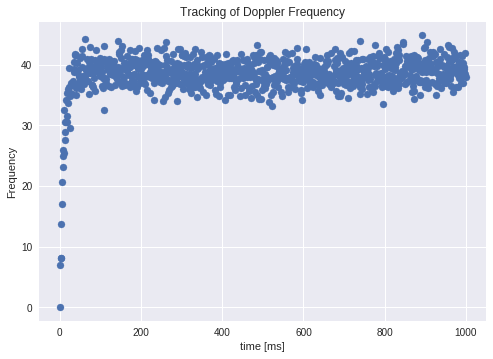

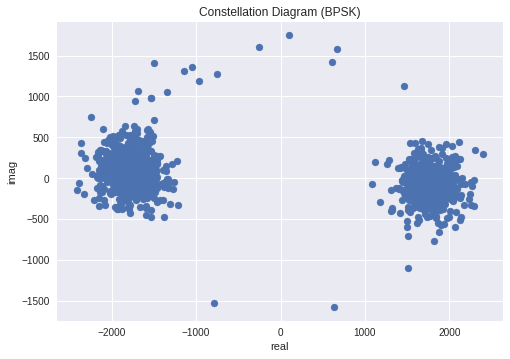

In [0]:
# Calculate expected doppler by drift of samples per second
chip_sample_diff = abs(trk_sample_idx[int(1/CODE_PERIOD-1)]-trk_sample_idx[0])
dopp_expect = chip_sample_diff * FCENTER / FS

# Calculate expected doppler by looking at tracking results of B1
dopp_b1 = 2670
fcenter_carr_b1 = 1526*1.023e6
fcenter_carr_b2a = FCENTER
dopp_est_carr = dopp_b1 / fcenter_carr_b1 * fcenter_carr_b2a

print('Initial Doppler :  %.2f Hz' % DOPP_FREQ_INIT)
print('Expected Doppler : %.2f Hz (from tracking sample difference)' % dopp_expect)
print('Estimated Doppler: %.2f Hz (from tracking results on B1)' % dopp_est_carr)
print('Tracked Doppler:   %.2f Hz' % dopp_freq[-1])

plt.figure()  
plt.title('Tracking of Doppler Frequency')
plt.ylabel('Frequency')
plt.xlabel('time [ms]')
plt.scatter(range(NUM_MS),dopp_freq)
plt.show()

# Transform complex values to cartesian
x = [n.real for n in xcorr_max.values()]
y = [n.imag for n in xcorr_max.values()]

# Plots
plt.scatter(x, y)
plt.title('Constellation Diagram (BPSK)')
plt.ylabel('imag')
plt.xlabel('real')
plt.show()

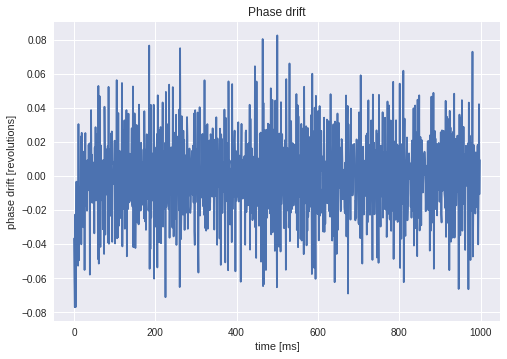

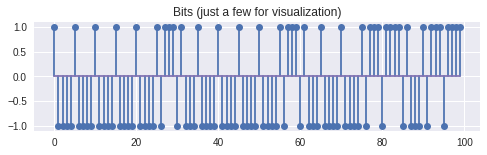

In [0]:
plt.figure()
plt.title('Phase drift')
plt.ylabel('phase drift [revolutions]')
plt.xlabel('time [ms]')
plt.plot(a_diff_vals.values())
plt.show()

plt.figure(figsize=(8,2))
plt.title('Bits (just a few for visualization)')
plt.stem(bits[:100])
plt.show()

Those are the navigation data symbols received, without stripping of the secondary code. According to the ICD, there is a 5 chip secondary code (`00010`) on the data, and a 100 chip secondary code on the pilot. A secondary code chip overlays an entire primary code period. A primary code period is 1 ms long, so the overall data rate is 200 Hz and the pilot sequence repeats every 100 ms. As one can see above, the short 5 bit sequence  on the data is verified as we tracked using 

## Conclusion

We could show the complete chain of signal processing from raw antenna data to data bits.

In order to demodulate the data bits to actual navigation data bit information, further processing, such as stripping the secondary codes would be required.

Due to time limitations we did not continue here, but readers can reproduce our results using the provided files.
